# Plot Clusters

In [3]:
import numpy as np
import halotools.mock_observables
import astropy.cosmology

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML

In [4]:
%run ~/.jupyter/config.ipy

# Data

In [5]:
data = np.load("/home/christopher/Data/data/universe_machine/final/sfr_catalog_insitu_exsitu_0.712400.txt.final.npz")
cens = data["centrals"]
gals = np.append(cens, data["satellites"])

# Find interesting region

In [6]:
x_cen, xr = 40, 20
y_cen, yr = 38, 5
z_cen, zr = 236, 5
subset = gals[
    (gals["x"] > x_cen-xr) & (gals["x"] < x_cen+xr) &
    (gals["y"] > y_cen-yr) & (gals["y"] < y_cen+yr) &
    (gals["z"] > z_cen-zr) & (gals["z"] < z_cen+zr) &
    (gals["mp"] > 1e12)
]
print(len(subset))

216


### How we found this region

In [ ]:
mcens = cens[(cens["mp"] > 10**14.2)]

xr, yr, zr = 20, 2, 2
for x_cen in range(0+xr, 400-xr, xr):
    print(f"x: {x_cen}")
    for y_cen in range(0+yr, 400-yr, yr):
        for z_cen in range(0+zr, 400-zr, zr):
            subset = mcens[
                (mcens["x"] > x_cen-xr) & (mcens["x"] < x_cen+xr) &
                (mcens["y"] > y_cen-yr) & (mcens["y"] < y_cen+yr) &
                (mcens["z"] > z_cen-zr) & (mcens["z"] < z_cen+zr)
            ]
            if len(subset) > 1:
                print(x_cen, y_cen, z_cen)
                print(subset["id"])


# Plot

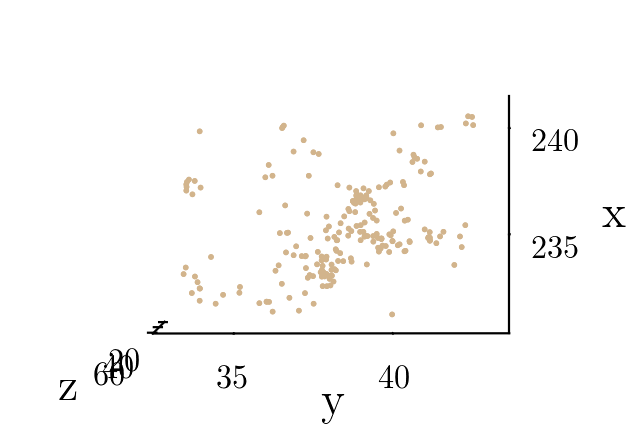

In [33]:
fig = plt.figure(figsize=mpl.small_plotsize)
ax = Axes3D(fig, azim=0, elev=0)

plt.locator_params(nbins=4)



# make the panes transparent
for _ax in [ax.xaxis, ax.yaxis, ax.zaxis]:
    _ax.set_pane_color((1.0, 1.0, 1.0, 0.0))
    _ax._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_zticks = [ax.get_zticks()[0], ax.get_zticks()[-1]]
ax.set_xtick_labels = [ax.get_xticks()[0], ax.get_xticks()[-1]]

colors = ["blueviolet", "black", "orangered", "forestgreen"]
def init():
    
    # This will overlay
    ids, counts = np.unique(subset["upid"], return_counts=True)
    important_cluster_ids = ids[(counts > 600) & (ids != -1)]
    for i, cluster_id in enumerate(important_cluster_ids):
        cluster = subset[
            (subset["upid"] == cluster_id) |
            (subset["id"] == cluster_id)
        ]
        ax.scatter(cluster["x"], cluster["y"], cluster["z"], s=1, alpha=1, c=colors[i])
    
    no_cluster = subset[
        np.logical_not(np.isin(subset["upid"], important_cluster_ids)) &
        np.logical_not(np.isin(subset["id"], important_cluster_ids))
    ]
    ax.scatter(no_cluster["x"], no_cluster["y"], no_cluster["z"], s=1, alpha=1, c="tan")
    ax.set(xlabel="z", ylabel="y", zlabel="x")
    return fig,


n_frames = 360
def animate(i):
    angle = i * 360 / n_frames
    ax.view_init(azim=angle)
    return fig,


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames, interval=50, blit=True)

#HTML(anim.to_html5_video())
anim.save("no_clusters.avi", fps=30, extra_args=['-vcodec', 'libx264'])
#anim.save("with_clusters.avi", fps=30, extra_args=['-vcodec', 'libx264'])

# Proj effects

In [25]:
#most_massive = cens[np.argmax(cens["m"])]
most_massive = cens[cens["m"] > 10**14.5][1]
print(np.log10(most_massive["m"]))
most_massive_gals = np.append(most_massive, gals[gals["upid"] == most_massive["id"]])
most_massive_gals = most_massive_gals[most_massive_gals["mp"] > 1e12]
print(len(most_massive_gals))

14.76417613239033
33


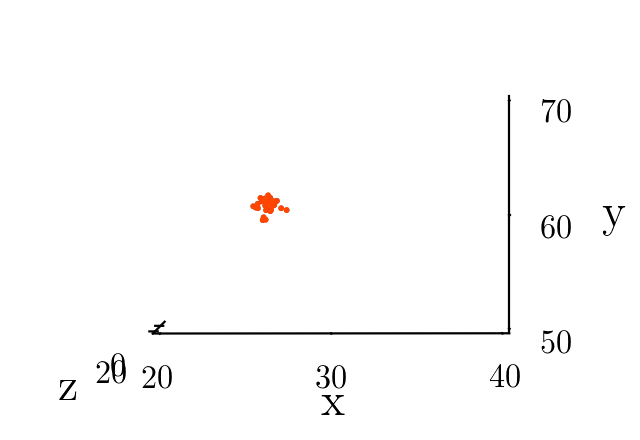

In [27]:
fig = plt.figure(figsize=mpl.small_plotsize)
ax = Axes3D(fig, azim=0, elev=0)

plt.locator_params(nbins=3)

# make the panes transparent
for _ax in [ax.xaxis, ax.yaxis, ax.zaxis]:
    _ax.set_pane_color((1.0, 1.0, 1.0, 0.0))
    _ax._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_zticks = [ax.get_zticks()[0], ax.get_zticks()[-1]]
ax.set_xtick_labels = [ax.get_xticks()[0], ax.get_xticks()[-1]]
ax.set(zlim=(50, 70), ylim=(20, 40), xlabel="z", ylabel="x", zlabel="y")

def init():
    ax.scatter(most_massive_gals["z"], most_massive_gals["x"], most_massive_gals["y"], s=1, alpha=1, label="Real space", color="skyblue")
    ax.scatter(
        halotools.mock_observables.apply_zspace_distortion(most_massive_gals["z"], most_massive_gals["vz"], 0.4, astropy.cosmology.Planck15),
        most_massive_gals["x"],
        most_massive_gals["y"],
        s=1,
        alpha=1,
        label="Redshift space",
        color="orangered",
    )

    return fig,
"""
ax.legend(fontsize="small", loc="upper right")
ax.legend(fontsize="small", loc="upper right")
ax.set(xlabel="x (Mpc)", ylabel="z (Mpc)")
"""

n_frames = 360
def animate(i):
    angle = i * 360 / n_frames
    ax.view_init(azim=angle)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames, interval=50, blit=True)

#HTML(anim.to_html5_video())
anim.save("cigar.avi", fps=30, extra_args=['-vcodec', 'libx264'])

[Text(0, 0.5, 'z (Mpc)'), Text(0.5, 0, 'x (Mpc)')]

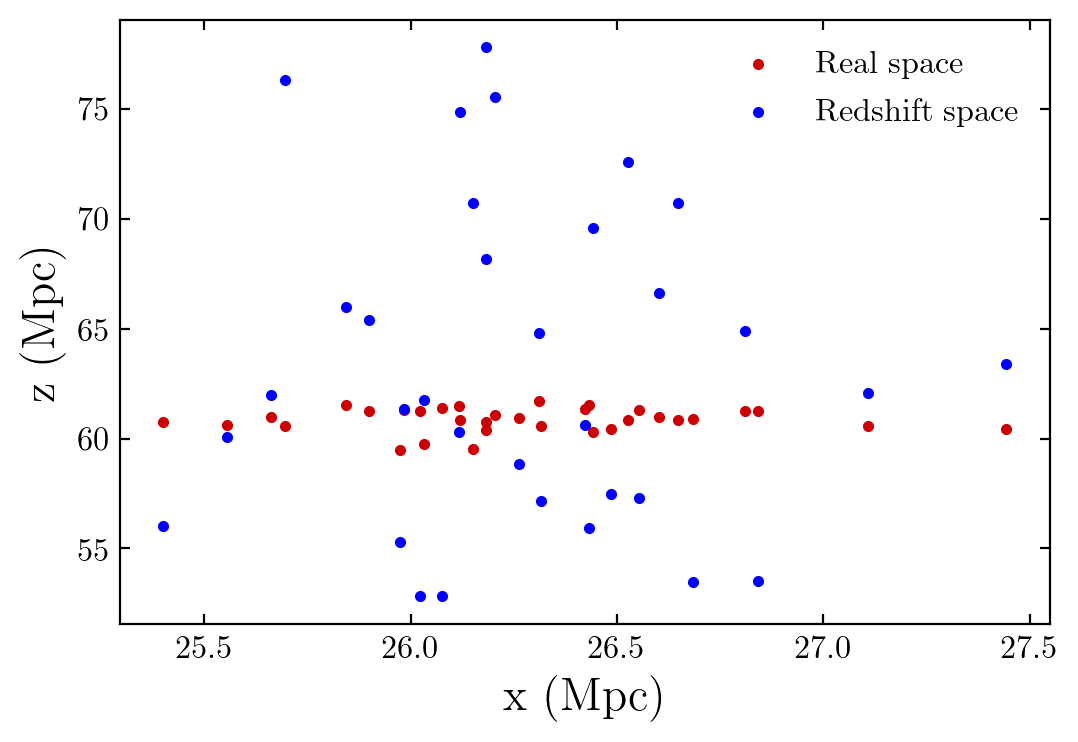

In [212]:
_, ax = plt.subplots()
ax.scatter(most_massive_gals["x"], most_massive_gals["y"], label="Real space")
ax.legend(fontsize="small", loc="upper right")
ax.scatter(most_massive_gals["x"], halotools.mock_observables.apply_zspace_distortion(most_massive_gals["y"], most_massive_gals["vy"], 0.4, astropy.cosmology.Planck15), label="Redshift space")
ax.legend(fontsize="small", loc="upper right")
ax.set(xlabel="x (Mpc)", ylabel="z (Mpc)")